In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('emotion-classification-pytorch')
jovian.set_colab_id('1ngFXIbLh1HIJL2UkuyhPMcBo8JXzNMQP')

     |████████████████████████████████| 71kB 8.5MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import cv2
import random as rnd
%matplotlib inline

In [3]:
!pip install opendatasets --quiet --upgrade

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jithinnambiarj/fer2013modified'

od.download(dataset_url)

 11%|█▏        | 9.00M/79.3M [00:00<00:01, 60.0MB/s]

100%|██████████| 79.3M/79.3M [00:00<00:00, 95.4MB/s]

In [5]:
data_dir_path = 'fer2013modified/Emotion Updated 1'

# Read and Analyze data

In [6]:
train_dir_path = data_dir_path + '/train/'
test_dir_path = data_dir_path + '/test/'

In [7]:
classes = os.listdir(train_dir_path)

In [8]:
classes

['control', 'neutral', 'angry', 'sad', 'happy']

In [9]:
def show_img(path):
    plt.figure(figsize=(5,5))
    imgs = cv2.imread(path)
    print("Shape of the Image: ",imgs.shape)
    plt.imshow(imgs)

Label :  sad
Shape of the Image:  (48, 48, 3)
Label :  angry
Shape of the Image:  (48, 48, 3)
Label :  happy
Shape of the Image:  (48, 48, 3)
Label :  angry
Shape of the Image:  (48, 48, 3)
Label :  sad
Shape of the Image:  (48, 48, 3)


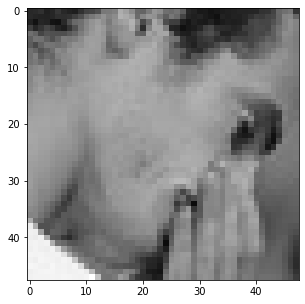

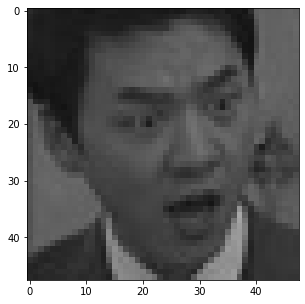

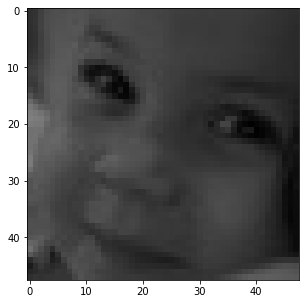

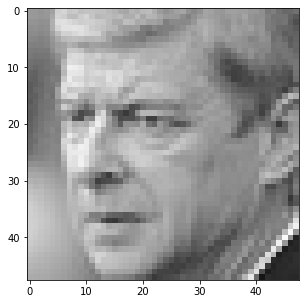

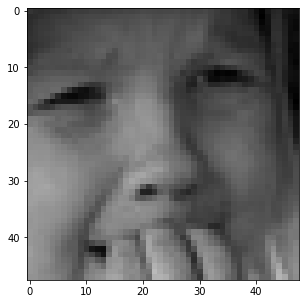

In [10]:
for i in range(5):
    cat = rnd.choice(os.listdir(train_dir_path))
    img = rnd.choice(os.listdir(train_dir_path+cat))
    path = train_dir_path+cat+"/"+img
    print("Label : ",cat)
    show_img(path)


From the above images we can see that all the images are grayscale and sizes of the images are different

In [11]:
for i in classes:
    path = train_dir_path+i
    print(f"Number of images in {i} train data class: {len(os.listdir(path))} ")

Number of images in control train data class: 4822 
Number of images in neutral train data class: 4965 
Number of images in angry train data class: 3995 
Number of images in sad train data class: 4830 
Number of images in happy train data class: 7215 


In [12]:
for i in classes:
    path = test_dir_path+i
    print(f"Number of images in {i} test data class: {len(os.listdir(path))} ")

Number of images in control test data class: 1559 
Number of images in neutral test data class: 1233 
Number of images in angry test data class: 958 
Number of images in sad test data class: 1247 
Number of images in happy test data class: 1774 


Therefore the average size of the list is [3, 76, 76]

In [13]:
input_shape = (1, 76, 76)

In [14]:
stats = ((0.5),(0.5))
train_transforms = tfs.Compose([
    tfs.Resize(input_shape[1:]),
    tfs.Grayscale(1),
    tfs.CenterCrop(56),
    tfs.RandomHorizontalFlip(),
    tfs.RandomRotation(10),
    tfs.ToTensor(),
    tfs.Normalize(*stats,inplace=True),
])

test_transforms = tfs.Compose([
    tfs.Resize(input_shape[1:]),
    tfs.Grayscale(1),
    tfs.ToTensor(),
    tfs.Normalize(*stats,inplace=True),
])

In [15]:
train_dataset = ImageFolder(root=train_dir_path,transform=train_transforms)
valid_dataset = ImageFolder(root=test_dir_path,transform=test_transforms)

In [16]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 25827
    Root location: fer2013modified/Emotion Updated 1/train/
    StandardTransform
Transform: Compose(
               Resize(size=(76, 76), interpolation=bilinear)
               Grayscale(num_output_channels=1)
               CenterCrop(size=(56, 56))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [17]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 6771
    Root location: fer2013modified/Emotion Updated 1/test/
    StandardTransform
Transform: Compose(
               Resize(size=(76, 76), interpolation=bilinear)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [18]:
batch_size = 128

In [19]:
train_loader = DataLoader(train_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)
valid_loader = DataLoader(valid_dataset,batch_size,num_workers=2,pin_memory=True)

In [20]:
for img, label in train_loader:
    print(img.shape)
    break

torch.Size([128, 1, 56, 56])


In [21]:
def denormalize(images, means, std):
  means = torch.tensor(means).reshape(1, 1, 1, 1)
  stds = torch.tensor(std).reshape(1, 1, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, label in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm = denormalize(images, *stats)
    ax.imshow(make_grid(denorm[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

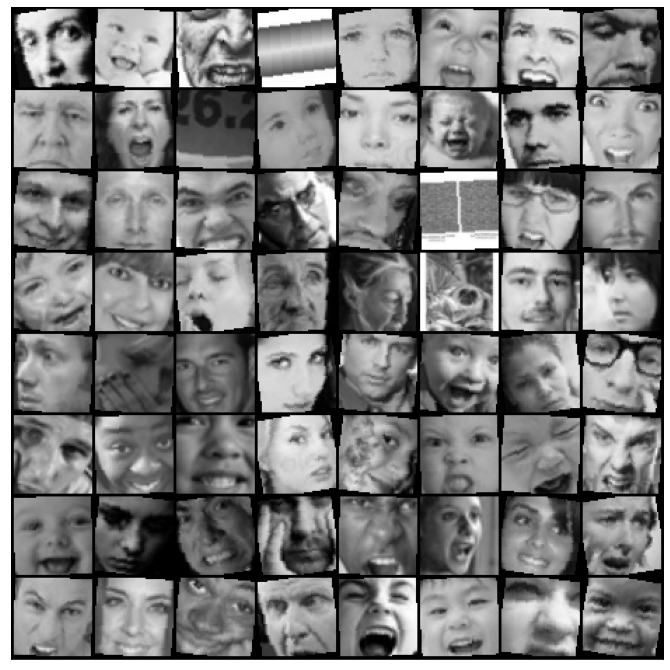

In [22]:
show_batch(train_loader)

 Above is the sample of images in a batch


# Using a GPU

In [23]:
def get_default_device():
  """Pick GPU if availabel, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data into device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ Yeild a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches"""
    return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

## Model 

In [26]:
class ImageClassificationBaseline(nn.Module):
  
  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = self.accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}

  def accuracy(self, outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / preds.numel())

  def validation_step_end(self, val_outputs, train_outputs):
    val_batch_losses = [x['val_loss'] for x in val_outputs]
    val_epoch_loss = torch.stack(val_batch_losses).mean()
    val_batch_acc = [x['val_acc'] for x in val_outputs]
    val_epoch_acc = torch.stack(val_batch_acc).mean()

    train_batch_losses = [x['val_loss'] for x in train_outputs]
    train_epoch_loss = torch.stack(train_batch_losses).mean()
    train_batch_acc = [x['val_acc'] for x in train_outputs]
    train_epoch_acc = torch.stack(train_batch_acc).mean()

    return {'train_loss':train_epoch_loss.item(), 'train_acc':train_epoch_acc.item(), 'val_loss':val_epoch_loss.item(), 'val_acc':val_epoch_acc.item()}

  def epoch_end(self, epoch, num_epochs, results):
    print("Epoch [{}/{}]: train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, num_epochs, 
                                    results['train_loss'], results['train_acc'], results['val_loss'], results['val_acc']))

In [27]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor( torch.sum(preds == labels).item() / preds.numel())


In [28]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBaseline):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    # 1 x 56 x 56
    self.conv1 = conv_block(in_channels, 64) # 64 x 56 x 56
    self.conv2 = conv_block(64, 128, pool=True) # 128 x 28 x 28
    self.res1 = nn.Sequential(conv_block(128, 128),
                              conv_block(128, 128)) # 128 x 28 x 28

    self.conv3 = conv_block(128, 256, pool=True) # 256 x 24 x 24
    self.conv4 = conv_block(256, 512, pool=True) # 512 x 7 x 7
    self.res2 = nn.Sequential(conv_block(512, 512),
                              conv_block(512, 512)) # 512 x 7 x 7
    
    self.classifier = nn.Sequential(nn.MaxPool2d(7),  # 512 x 1 x 1
                                    nn.Flatten(),     # 512
                                    nn.Dropout(0.2), 
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, num_classes))
    
  def forward(self, xb):

    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)

    return out
  

In [29]:
model = to_device(ResNet9(1, 5), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Train the Model

In [30]:
@torch.no_grad() # No need to calculate any gradients
def evaluate(model, val_loader, train_loader):
  model.eval() # Tells the model that it is evaluation step, so no backpropagation, dropout, and batch normalization during evaluation
  val_outputs = [model.validation_step(batch) for batch in val_loader]
  train_outputs = [model.validation_step(batch) for batch in train_loader]
  return model.validation_step_end(val_outputs, train_outputs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, weight_decay=0, grad_clip=None, opt_func = torch.optim.SGD):

  torch.cuda.empty_cache()
  history = []

  # setup custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # setup one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

  for epoch in range(1,epochs+1):
    # Training phase
    model.train() # Model is trained 
    lrs = []

    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()

      # Grad-Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record and update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation phase
    results = evaluate(model, valid_dl, train_dl)
    results['lrs'] = lrs
    model.epoch_end(epoch, epochs, results)
    history.append(results)

  return history


In [31]:
history = []
history = [evaluate(model, valid_loader, train_loader)]
history

[{'train_acc': 0.1866803914308548,
  'train_loss': 1.6087044477462769,
  'val_acc': 0.23157429695129395,
  'val_loss': 1.6074774265289307}]

We can see that before training the train accuracy is 15.47% and valid accuracy is 14.12%

In [32]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, valid_loader, opt_func=opt_func)

Epoch [1/50]: train_loss: 1.1879, train_acc: 0.5085, val_loss: 1.3748, val_acc: 0.3792
Epoch [2/50]: train_loss: 0.9814, train_acc: 0.6040, val_loss: 1.0592, val_acc: 0.5540
Epoch [3/50]: train_loss: 1.1378, train_acc: 0.5826, val_loss: 1.3017, val_acc: 0.4851
Epoch [4/50]: train_loss: 1.5082, train_acc: 0.5204, val_loss: 1.3806, val_acc: 0.5491
Epoch [5/50]: train_loss: 0.9805, train_acc: 0.6444, val_loss: 1.4235, val_acc: 0.5683
Epoch [6/50]: train_loss: 0.8776, train_acc: 0.6801, val_loss: 0.8731, val_acc: 0.6775
Epoch [7/50]: train_loss: 0.7956, train_acc: 0.6890, val_loss: 0.9678, val_acc: 0.6291
Epoch [8/50]: train_loss: 0.7811, train_acc: 0.7002, val_loss: 0.9106, val_acc: 0.6479
Epoch [9/50]: train_loss: 0.6940, train_acc: 0.7301, val_loss: 0.6759, val_acc: 0.7336
Epoch [10/50]: train_loss: 0.8656, train_acc: 0.6998, val_loss: 0.9859, val_acc: 0.6695
Epoch [11/50]: train_loss: 0.7329, train_acc: 0.7263, val_loss: 0.6667, val_acc: 0.7345
Epoch [12/50]: train_loss: 1.2017, train_

In [34]:
torch.save(model.state_dict(), 'emotion-classification-resnet9-50_epochs.pth')
jovian.commit(project = 'emotion-classification-Pytorch', environment=None, outputs=['emotion-classification-resnet9-50_epochs.pth'])

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Committed successfully! https://jovian.ai/developer-jnk/emotion-classification-pytorch


'https://jovian.ai/developer-jnk/emotion-classification-pytorch'

In [35]:
train_time = '52:31'

In [36]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [37]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [50]:
def plot_accuracies(history):
    train_acc = [x.get('train_acc') for x in history]
    val_acc = [x['val_acc'] for x in history]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

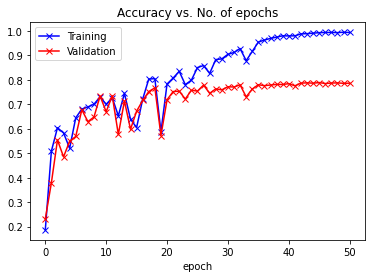

In [51]:
plot_accuracies(history)

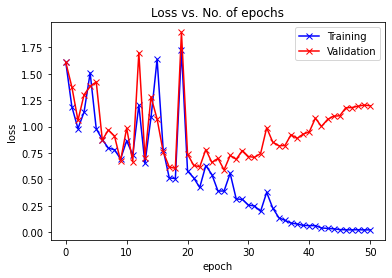

In [40]:
plot_losses(history)

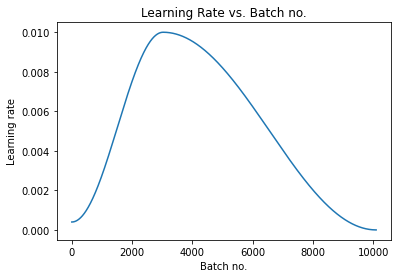

In [41]:
plot_lrs(history)

In [42]:
@torch.no_grad()
def get_all_preds(model, loader):
    loader = to_device(loader, device)
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0)
    return all_preds

In [43]:
from sklearn.metrics import confusion_matrix

nb_classes = 5

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print("Confusion Matrix is :\n",conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print("\nPer Class Accuracy is :\n",class_accuracy)

Confusion Matrix is :
 [[ 566    0   39  123  230]
 [   1 1555    0    1    2]
 [  39    1 1482  141  111]
 [  51    1   47  843  291]
 [  98    0   36  236  877]]

Per Class Accuracy is :
 [59.08141962 99.74342527 83.54002255 68.36982968 70.32878909]


## Commit Details to Jovian Account

In [44]:
!pip install jovian --upgrade --quiet
import jovian

In [54]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=0, 
                       grad_clip=None,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [55]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   train_acc=history[-1]['train_acc'],
                   time=train_time)

[jovian] Metrics logged.


In [58]:
torch.save(model.state_dict(), 'emotion-classification-resnet9_50.pth')

In [59]:
jovian.commit(project = 'emotion-classification-Pytorch', environment=None, outputs=['emotion-classification-resnet9_50.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/developer-jnk/emotion-classification-pytorch


'https://jovian.ai/developer-jnk/emotion-classification-pytorch'